# Lecture 05. Harris Corner Detector

## 1. Local Feature Descriptor

#### What is feature in Computer Vision?
- A feature is a **piece of information** which is relevant for solving the computational task related to a certain application

#### Why extract features?
- Many applications!!!
    - panoramas
    - image matching
    - 3d reconstruction
    - motion tracking
    - object recognition
    - etc.

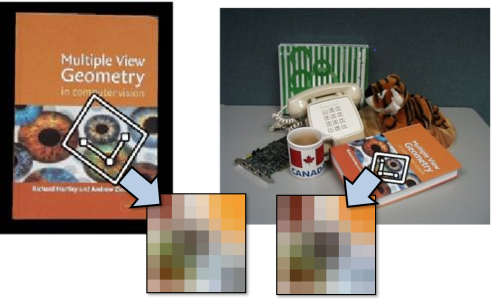

<br/>

#### Advantages of local features
- **Locality** : features are local, so robust to occlusion and clutter
- **Quantity** : hundreds or thousands in a single image
- **Distinctiveness** : can differentiate a large database of objects
- **Efficiency** : real-time perfomance achievable

### 1-1. Simple Approach for Image Matching (actually, it's not that simple..)

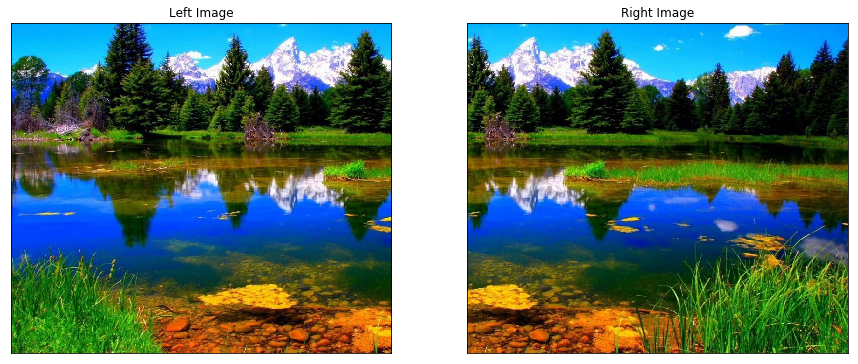

In [1]:
import numpy as np
import cv2
import math
from scipy import *
from scipy import signal
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

# load images
left = cv2.imread('images/left.jpg')
left = cv2.cvtColor(left, cv2.COLOR_BGR2RGB)
left_gray = cv2.cvtColor(left,cv2.COLOR_BGR2GRAY)

right = cv2.imread('images/right.jpg')
right = cv2.cvtColor(right, cv2.COLOR_BGR2RGB)
right_gray = cv2.cvtColor(right,cv2.COLOR_BGR2GRAY)

# utility function for displaying multiple images
# code source : https://github.com/MLman/computer-vision-AAA534/blob/master/01-image%20filtering/01-linear%20filtering.ipynb
def ShowImgs(images, titles, row, column, size):
    fig = plt.figure(figsize = size)
    for i in range(len(images)):
        fig.add_subplot(row, column, i+1), plt.imshow(images[i], cmap="gray"), plt.title(titles[i])
        plt.xticks([]),plt.yticks([])
    plt.show()

ShowImgs([left, right], ["Left Image", "Right Image"], 1, 2, (15, 15))

#### Step1. Detection : Identify the interest points
#### Step2. Description : Extract vector feature descriptor surrounding each interest point

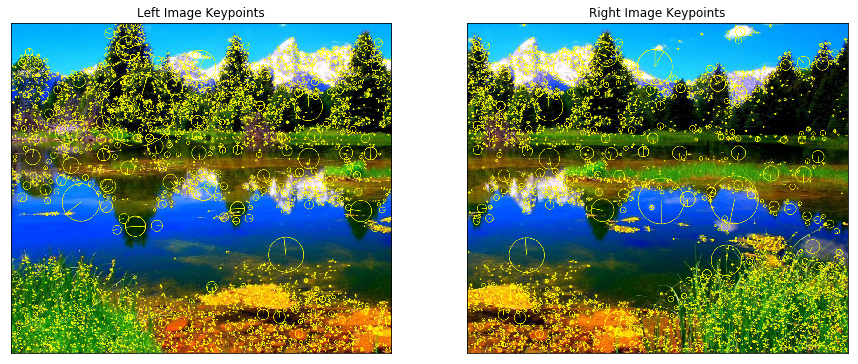

In [2]:
# code source : https://medium.com/pylessons/image-stitching-with-opencv-and-python-1ebd9e0a6d78
# generate feature extractor (I used SIFT feature which is not introduced in this doc.)
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
left_kp, left_des = sift.detectAndCompute(left_gray,None)
right_kp, right_des = sift.detectAndCompute(right_gray,None)

# plot keypoints on the images
flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
img_with_keypoints_left = cv2.drawKeypoints(left, left_kp, outImage=np.array([]), color=(255, 255, 0), flags=flags)
img_with_keypoints_right = cv2.drawKeypoints(right, right_kp, outImage=np.array([]), color=(255, 255, 0), flags=flags)
titles = ["Left Image Keypoints", "Right Image Keypoints"]
ShowImgs([img_with_keypoints_left, img_with_keypoints_right], titles, 1, 2, (15, 15))

#### Step3. Matching : Determine correspondence between descriptors in two views

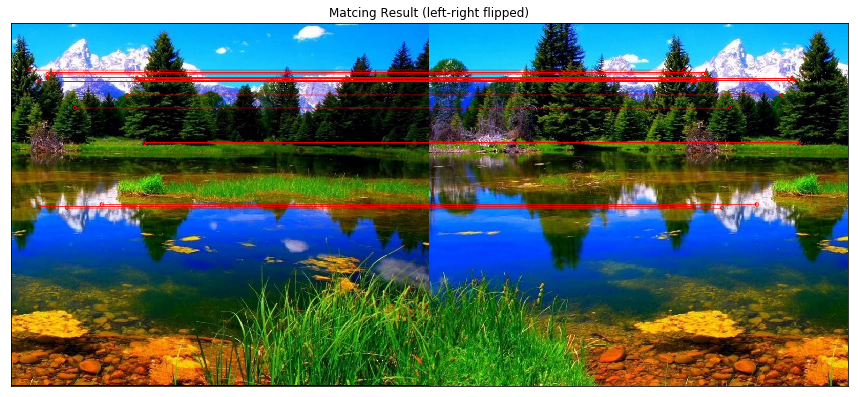

In [3]:
# matching with k-nearest neighbors
match = cv2.BFMatcher()
matches = match.knnMatch(right_des, left_des, k=2)

# suppress distant keypoints
good = []
for m,n in matches:
    if m.distance < 0.03*n.distance:
        good.append(m)
        
draw_params = dict(matchColor=(255, 0, 0), singlePointColor=None, flags=2)
img_match = cv2.drawMatches(right, right_kp, left, left_kp, good, None, **draw_params)
ShowImgs([img_match], ["Matcing Result (left-right flipped)"], 1, 1, (15, 15))

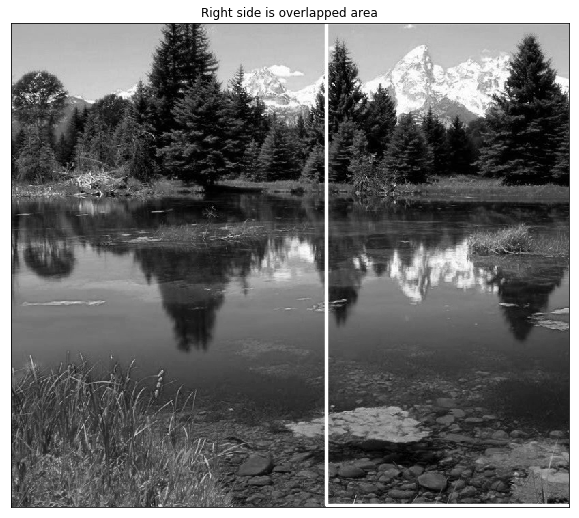

In [4]:
# run RANSAC to estimate homography (this is also not the coverage of this doc.)
MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([right_kp[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([left_kp[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    h, w = right_gray.shape
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)
    img_overlap = cv2.polylines(left_gray, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
    ShowImgs([img_overlap], ["Right side is overlapped area"], 1, 1, (10, 10))
else:
    print("Not enought matches are found - %d/%d", (len(good)/MIN_MATCH_COUNT))

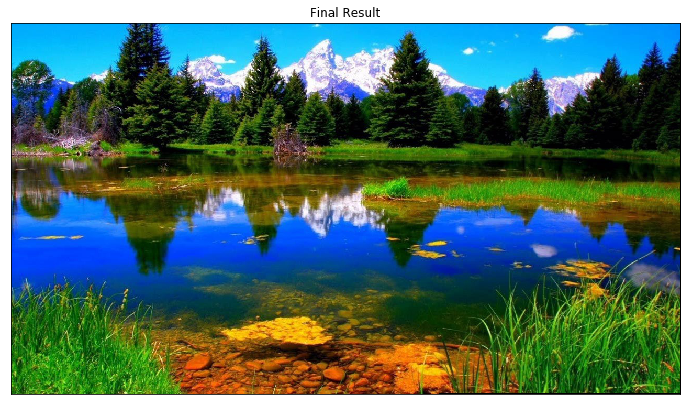

In [5]:
# stitch images
dst = cv2.warpPerspective(right, M, (left.shape[1] + right.shape[1], left.shape[0]))
dst[0:left.shape[0], 0:left.shape[1]] = left
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop top
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop top
    if not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    #crop top
    if not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
    return frame
ShowImgs([trim(dst)], ["Final Result"], 1, 1, (12, 12))

---------------------------

## 2. Harris Corner Detector

#### What makes good features?
- Look for image regions that are unusual
    - Lead to umambiguous matches in other images
- How to define **"UNUSUAL"**?

#### Answer : CORNER
- the point which causes a big change when shifting the window in any direction

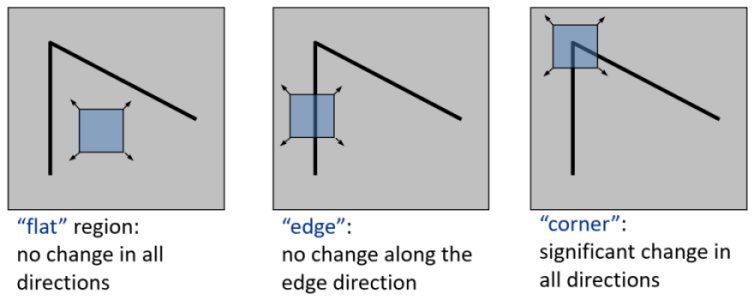

### 2-1. Formula Derivation

#### Error Function
- Consider shifting the window $W$ by $(u, v)$
- Compare each pixel before and after by summing up the squared differences (SSD)
- This defines an SSD **"error"** $E(u, v)$ : 

<br/>

$$
E(u, v) = \sum_{(x, y) \in W} [I(x+u, y+v) - I(x, y)]^2
$$

<br/>

- We are happy if this error is high (because it is unusual!!)
- However, it is very slow to compute exactly for each pixel and each offset $(u, v)$

<br/>

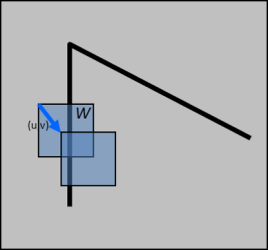

<br/>

#### Small Motion Assumption
- Taylor series expansion of $I$ :

<br/>

$$
I(x+u, y+v) = I(x, y) + \frac{\partial I}{\partial x}u + \frac{\partial I}{\partial y}v + \text{higher order terms}
$$

<br/>

- If the motion $(u, v)$ is small, the first order approximation is good

<br/>

$$
I(x+u, y+v) \;\; \approx \;\; I(x, y) + \frac{\partial I}{\partial x}u + \frac{\partial I}{\partial y}v \;\; \approx \;\;
I(x, y) +
\begin{bmatrix}
I_x & I_y
\end{bmatrix}
\begin{bmatrix}
u \\
v
\end{bmatrix}
$$

<br/>

- Plug this into the formula on the previous slide

<br/>

$$
\begin{align}
E(u, v) & = \sum_{(x, y) \in W} [I(x+u, y+v) - I(x, y)]^2 \\
& \approx \sum_{(x, y) \in W} [I(x, y) + I_x u + I_y v - I(x, y)]^2 \\
& \approx \sum_{(x, y) \in W} [I_x u + I_y v]^2 \\
& \approx Au^2 + 2Buv + C v^2 \\
\end{align}
$$

<br/>

$$
\text{when, } 
\;\;\;\; A = \sum_{(x, y) \in W} {I_x}^2 
\;\;\;\; B = \sum_{(x, y) \in W} {I_x}{I_y} 
\;\;\;\; C = \sum_{(x, y) \in W} {I_y}^2 
$$

<br/>

- Thus, $E(u, v)$ is locally approximated as a quadratic error function

---

#### The Second Moment Matrix
- The surface $E(u, v)$ is locally approximated by a quadratic form

<br/>

$$
\begin{align}
E(u, v) & \approx Au^2 + 2Buv + C v^2 \\
& =
\begin{bmatrix}
u & v
\end{bmatrix}
\begin{bmatrix}
A & B \\
B & C
\end{bmatrix}
\begin{bmatrix}
u \\
v
\end{bmatrix}
\end{align}
$$

<br/>

- Let the middle matrix as $H$.

<br/>

$$
H = 
\begin{bmatrix}
A & B \\
B & C
\end{bmatrix}
$$

<br/>

- Eigenvalues and Eigenvectors of $H$
    - Define shift directions with the smallest and largest change in error
    - $x_{max}$ = direction of largest increase in $E(u, v)$
    - $\lambda_{max}$ = amount of increase in direction $x_{max}$
    - $x_{min}$ = direction of smallest increase in $E(u, v)$
    - $\lambda_{min}$ = amount of increase in direction $x_{min}$
    
<br/>

$$
H x_{max} = \lambda_{max} x_{max} \\
H x_{min} = \lambda_{min} x_{min}
$$

<br/>

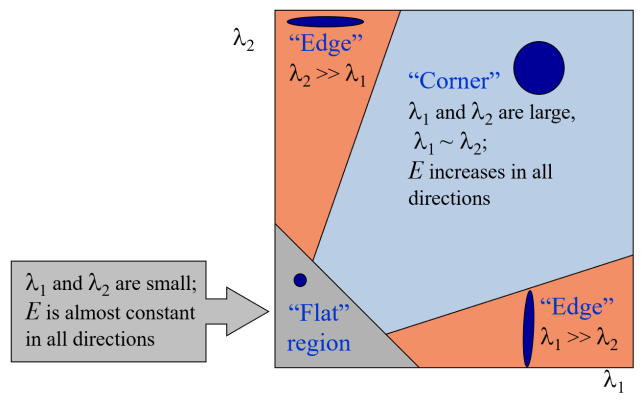

<br/>

### 2-2. How to detect corners with the formula

- Step1 : Compute the gradient at each point in the image
- Step2 : Create the H matrix from the entries in the gradient
- Step3 : Compute the eigenvalues
- Step4 : Find points with large response ($\lambda_{min} > \text{threshold}$)
- Step5 : Choose those points where $\lambda_{min}$ is a local maximum as features

#### Harris Operator
- $\lambda_{min}$ is a variant of the **"Harris Operator"** for feature detection
- The trace is the sum of the diagonals
- Very similar to $\lambda_{min}$, but less expensive (no square root)
- Called the "Harris Corner Detector" or "Harris Operator"
- Lots of other detectors, this is one of the most popular

<br/>

$$
f = \frac{\lambda_1 \lambda_2}{\lambda_1 + \lambda_2} = \frac{determinant(H)}{trace(H)}
$$

<br/>

In [6]:
# load an image
img = cv2.imread("images/Checkered_Floor.jpg", 0)
img_color = cv2.imread("images/Checkered_Floor.jpg")
img_color = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)

#### Step1 : Compute the gradient

In [7]:
# gaussian filter would be helpful for getting better gradient
# so we use the derivative of gaussian filter
# code source : http://www.kaij.org/blog/?p=89
def gauss_derivative_kernels(size, sizey=None):
    """ returns x and y derivatives of a 2D 
        gauss kernel array for convolutions """
    size = int(size)
    if not sizey:
        sizey = size
    else:
        sizey = int(sizey)
    y, x = mgrid[-size:size+1, -sizey:sizey+1]

    # x and y derivatives of a 2D gaussian with standard dev half of size
    # (ignore scale factor)
    gx = - x * exp(-(x**2/float((0.5*size)**2)+y**2/float((0.5*sizey)**2))) 
    gy = - y * exp(-(x**2/float((0.5*size)**2)+y**2/float((0.5*sizey)**2))) 
    return gx,gy

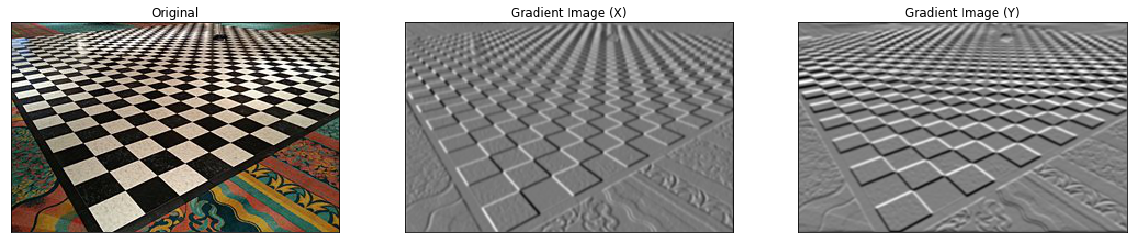

In [8]:
# get gradient of image
gx, gy = gauss_derivative_kernels(3)
img_grad_x = signal.convolve(img, gx, mode='same')
img_grad_y = signal.convolve(img, gy, mode='same')

# plot images
titles = ["Original", "Gradient Image (X)", "Gradient Image (Y)"]
ShowImgs([img_color, img_grad_x, img_grad_y], titles, 1, 3, (20, 20))

#### Step2 : Compute the H matrix and harris operator

In [9]:
# function for get harris operator
# gaussian kernel is used as a window
def compute_harris_response(imx, imy):
    """ compute the Harris corner detector response function 
        for each pixel in the image"""
    
    def gauss_kernel(size, sizey = None):
        """ Returns a normalized 2D gauss kernel array for convolutions """
        size = int(size)
        if not sizey:
            sizey = size
        else:
            sizey = int(sizey)
        x, y = mgrid[-size:size+1, -sizey:sizey+1]
        g = exp(-(x**2/float(size)+y**2/float(sizey)))
        return g / g.sum()
    
    #kernel for blurring
    gauss = gauss_kernel(3)
    
    #compute components of the structure tensor
    Wxx = signal.convolve(imx*imx, gauss, mode='same')
    Wxy = signal.convolve(imx*imy, gauss, mode='same')
    Wyy = signal.convolve(imy*imy, gauss, mode='same')
    
    #determinant and trace
    Wdet = Wxx*Wyy - Wxy**2
    Wtr = Wxx + Wyy
    
    return Wdet / Wtr

In [10]:
harris = compute_harris_response(img_grad_x, img_grad_y)
print("shape of harris operator matrix : ", harris.shape)

shape of harris operator matrix :  (192, 300)


#### Step3 : Find points with large response

In [11]:
def get_harris_points(harrisim, min_distance=10, threshold=0.1):
    """ return corners from a Harris response image
        min_distance is the minimum nbr of pixels separating 
        corners and image boundary"""

    #find top corner candidates above a threshold
    corner_threshold = max(harrisim.ravel()) * threshold
    harrisim_t = (harrisim > corner_threshold) * 1
    
    #get coordinates of candidates
    candidates = harrisim_t.nonzero()
    coords = [(candidates[0][c],candidates[1][c]) for c in range(len(candidates[0]))]
    #...and their values
    candidate_values = [harrisim[c[0]][c[1]] for c in coords]
    
    #sort candidates
    index = argsort(candidate_values)
    
    #store allowed point locations in array
    allowed_locations = zeros(harrisim.shape)
    allowed_locations[min_distance:-min_distance,min_distance:-min_distance] = 1
    
    #select the best points taking min_distance into account
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i][0]][coords[i][1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i][0]-min_distance):(coords[i][0]+min_distance),
                (coords[i][1]-min_distance):(coords[i][1]+min_distance)] = 0
                
    return filtered_coords

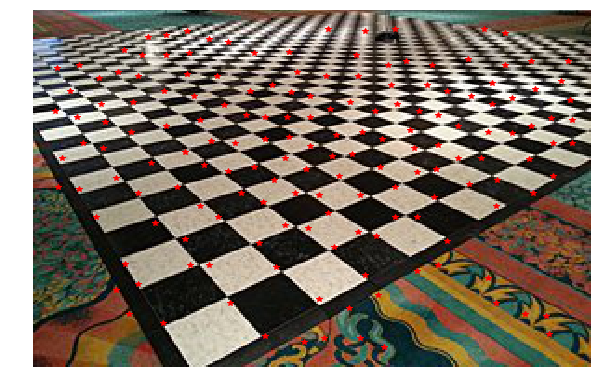

In [12]:
corner_idx = get_harris_points(harris)

# plot the detected corners
plt.figure(figsize=(10, 10)); plt.imshow(img_color)
plt.plot([p[1] for p in corner_idx],[p[0] for p in corner_idx], '*', color='r')
plt.axis('off'); plt.show()

#### Simple opencv code

(-0.5, 299.5, 191.5, -0.5)

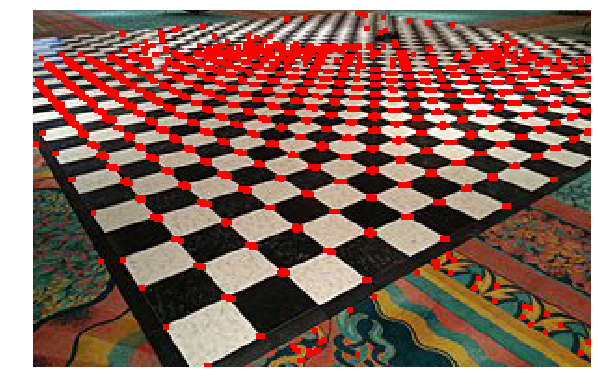

In [13]:
dst = cv2.cornerHarris(img, 2, 3, 0.15)
dst = cv2.dilate(dst, None)
img_copy = img_color.copy()
img_copy[dst > (0.01*dst.max())] = [255, 0, 0]
plt.figure(figsize=(10, 10)); plt.imshow(img_copy); plt.axis('off')

### 2-3. Problem of Harris Corner Detector

#### Diagonal Edge
- Diagonal Egdes are detected as a corner with assumptions in Harris Detector

<br/>

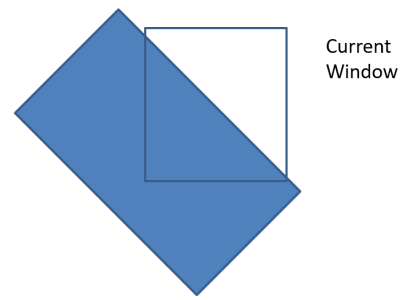

<br/>

#### Scale Variant property

<br/>

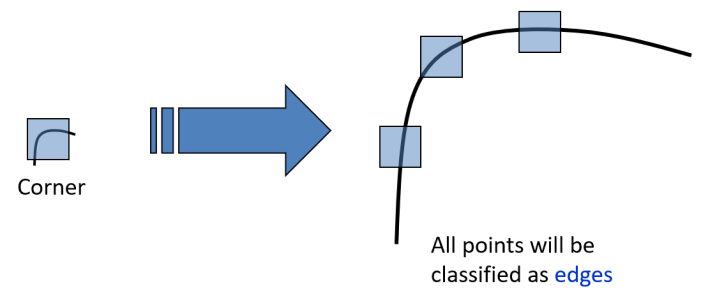

<br/>

##### ※ Invariance and Equivariance
- We want corner locations to be invariant to photometric transformations and equivariant to geometric transformations
    - **Invariance** : image is transformed and corner locations do not change
    - **Equivariance** : if we have two transformed versions of the same image, features should be detected in corresponding locations
    - Sometimes **Invariant** and **Equivariant** are both referred to as **Invariant**
    - Sometimes **Equivariant** is called **Covariant**

#### Solution
- Find scale that gives local maximum of $f$(Harris Operator)

<br/>

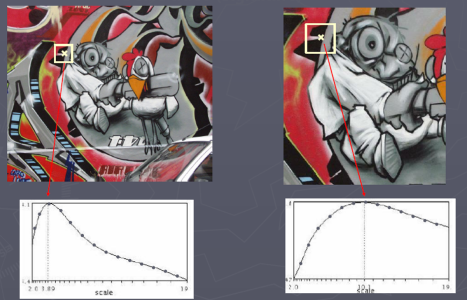

<br/>

## 3. Blob Detector

#### What is Blob?
- Blob is a group of connected pixels in an image that share some common property (e.g grayscale value)

<br/>

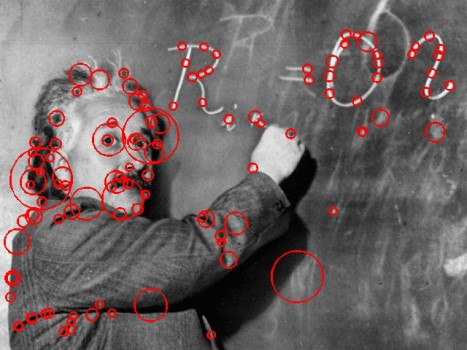

<br/>

### 3-1. How to detect blob

- Laplacian of Gaussian kernel is popularly used

<br/>

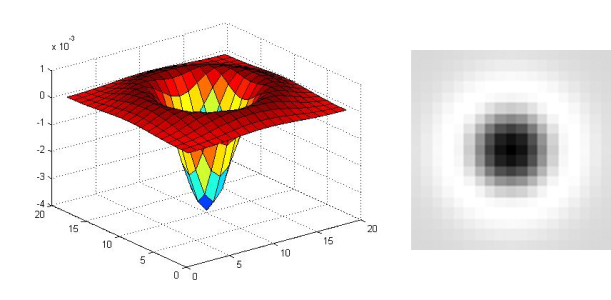

<br/>

- At what scale does the Laplacian achieve a maximum response for a binary circle of radius r?

<br/>

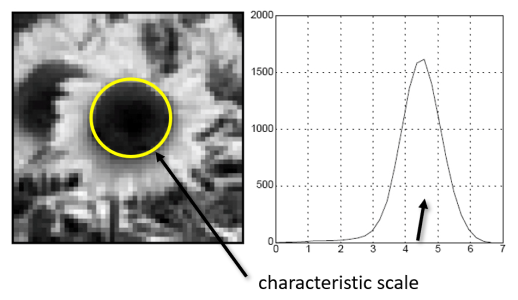

<br/>

- We define the characteristic scale as the scale that produces peak of Laplacian response

### 3-2. simple code example

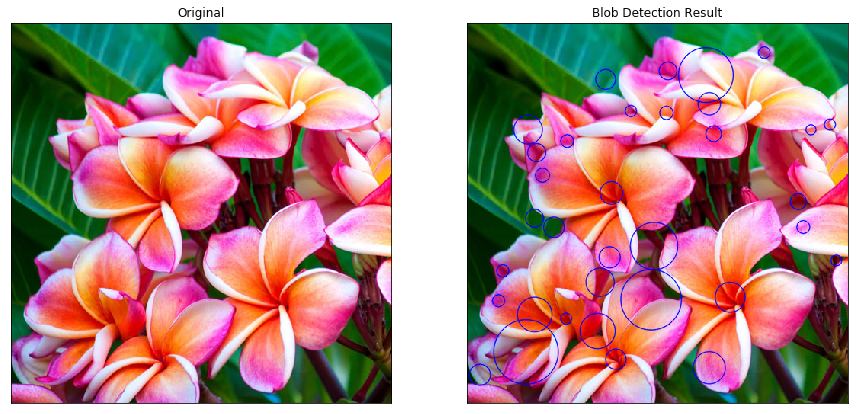

In [14]:
# code source : https://www.learnopencv.com/blob-detection-using-opencv-python-c/
img_gray = cv2.imread("images/flower.jpg", 0)
img = cv2.imread("images/flower.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# setting parameters of blob detector
params = cv2.SimpleBlobDetector_Params()
 
# Filter by Area.
params.filterByArea = True
params.minArea = 80
 
# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.1
 
# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.1

# generate the baisic blob detector
detector = cv2.SimpleBlobDetector_create(params)

# keypoints generation
keypoints = detector.detect(img_gray)
im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

ShowImgs([img, im_with_keypoints], ["Original", "Blob Detection Result"], 1, 2, (15, 15))